# EEE 197z Project 1 - Zero Shot Object Detection
use SAM to perform zero-shot object detection using COCO 2017 val split. 

*Author: Sean Red Mendoza | 2020-01751 | scmendoza5@up.edu.ph*

## Tools/ References
- [SegmentAnything](https://github.com/facebookresearch/segment-anything)
- [OpenClip](https://github.com/mlfoundations/open_clip)
- [Coco 2017 Validation Dataset](https://cocodataset.org/#home)
- [roatienza/mlops](https://github.com/roatienza/mlops)
- [roatienza/Deep-Learning-Experiments](https://github.com/roatienza/Deep-Learning-Experiments)
- [Google Cloud G2 GPU VM (Nvidia L4)](https://cloud.google.com/blog/products/compute/introducing-g2-vms-with-nvidia-l4-gpus)

## Goals

## Approach

## Notes


In [106]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import torch
import torchvision
from skimage import io
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import os

import open_clip
from PIL import Image
from pprint import pprint
import json
import shutil
import re
import urllib

import cv2
import urllib.request
import validators
from pytriton.client import ModelClient

import csv


In [107]:
# toggle on verbose logging for some of the functions
VERBOSE_LOGGING = False

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
print("[setup]: determining CUDA support...")
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

[setup]: determining CUDA support...
PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True


In [108]:
# clean output directory
if not os.path.exists("../output"):
    os.mkdir(f"../output")
shutil.rmtree("../output/")
os.mkdir(f"../output/")

In [109]:
sam_checkpoint = os.path.join("../checkpoints", "sam_vit_h_4b8939.pth")
print("[sam]: loading checkpoint file...")
# Download the file if it does not exist
url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
if not os.path.isfile(sam_checkpoint):
    urllib.request.urlretrieve(url, sam_checkpoint)

print("[sam]: loading segment_anything model...")
model_type = "vit_h"
device_one = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.to(device=device_one)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    points_per_batch=128,
    pred_iou_thresh=0.85,
    box_nms_thresh=0.2, # prevent overlapping of masks
    stability_score_thresh = 0.2, # allow masks to cover "entire objects"
    stability_score_offset = 0.5,
    crop_nms_thresh=0.8,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=4000,  # Requires open-cv to run post-processing,
)
print("[sam]: done loading segment_anything model!")

[sam]: loading checkpoint file...
[sam]: loading segment_anything model...
[sam]: done loading segment_anything model!


In [110]:

print("[0]: loading coco annotations and captions...")
dataDir = '../coco'
dataType = 'val2017'
annFile = '{}/annotations/instances_{}.json'.format(dataDir, dataType)

if not os.path.isfile(annFile):
    print("please download the coco val2017 instances dataset!")
    print("http://images.cocodataset.org/annotations/annotations_trainval2017.zip")
    quit()

# initialize COCO api for instance annotations + COCO ground truth api
cocoGt = COCO(annFile)
annFile = '{}/annotations/captions_{}.json'.format(dataDir, dataType)
coco_caps = COCO(annFile)
catIDs = cocoGt.getCatIds()
cats = cocoGt.loadCats(catIDs)
cocoCategories = [cat['name'] for cat in cats]
if VERBOSE_LOGGING:
    for i in range(len(cocoCategories)):
        print(i, cocoCategories[i])
        
paperlabels_filename = "../labels/coco-labels-paper.txt"  
with open(paperlabels_filename, "r") as file:
    lines = file.readlines()  
cocopaper_labels = [line.strip() for line in lines]


[0]: loading coco annotations and captions...
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [111]:

print("[open-clip]: creating open clip model...")
modelType = 'ViT-bigG-14'
modelDataset = "laion2b_s39b_b160k"
model, _, preprocess = open_clip.create_model_and_transforms(
    modelType, pretrained=modelDataset)
tokenizer = open_clip.get_tokenizer(modelType)
device_two = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device_two)

print("[open-clip]: done open clip model!")

[open-clip]: creating open clip model...
[open-clip]: done open clip model!


In [112]:
model_labels = []

print("[open-clip]: generating openclip labels dataset...")
# use coco paper categories as labels
model_labels.extend(cocopaper_labels)

# use SIMPLE IMAGENET LABELS

filename = "../labels/imagenet-simple-labels.json"
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"

# Download the file if it does not exist
if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)

with open(filename) as f:
    raw_imagenet_labels = eval(f.read())
imagenet_labels = []
for imagenet_label in raw_imagenet_labels:
    imagenet_labels.append(imagenet_label.lower().strip())
# if input_mode == "manual":
#     model_labels.extend(imagenet_labels)


# use Open Images Classes Dataset 
# from https://storage.googleapis.com/openimages/2017_11/classes_2017_11.tar.gz

filter_filename = "../labels/classes-bbox.txt"  
with open(filter_filename, "r") as file:
    lines = file.readlines()  
filter_classes = [line.strip() for line in lines]
labels_filename = '../labels/openimages-classes-raw.csv'
openimage_data = []
with open(labels_filename, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if (row[0] in filter_classes):
            openimage_data.append(row[1])

column_index = 1  
openimage_labels = [word.lower().strip() for word in openimage_data]
# if input_mode == "manual":
#     model_labels.extend(openimage_labels)

# PROCESS LABELS
# model_labels.append("unknown")
model_labels = list(set(model_labels)) # remove duplicates from wordlist
if VERBOSE_LOGGING:
    pprint(model_labels)
text = tokenizer(model_labels)
text = text.to(device_two)

print("[open-clip]: done generating openclip labels dataset!")


[open-clip]: generating openclip labels dataset...
[open-clip]: done generating openclip labels dataset!


## Images
This program supports manual entry of input image links or random sampling from the CoCo 2017 Validation Dataset
*Please select your desired input method below:*

- [1] Input Images
- [2] CoCo Images

After selecting the input image source, you will be asked to input the following:
- [a] List of image URL strings, or
- [b] number of random images sourced from CoCo 2017*

**a hard limit of 10 images is set to prevent overloading of the system*

In [113]:
user_input = "../images/dog_car.jpg"

def get_valid_input():
    while True:
        user_input = input("Enter image link (leave blank for random image):")
        if user_input == "":
            return "random"
        elif validators.url(user_input):
            return "manual"
        else:
            print("Invalid input. Please enter a valid image link.")
            return "manual"
            

input_mode = get_valid_input()

if input_mode == "manual":
    print(f"You have selected MANUAL image analysis of {user_input}")
elif input_mode == "random":
    print(f"You have selected a RANDOM image analysis from the CoCo 2017 dataset")

Invalid input. Please enter a valid image link.
You have selected MANUAL image analysis of ../images/dog_car.jpg


In [114]:
image_category_ID = 0
image_ID = 0
image_area = 0
image_link = ""
image_ground_truth_labels = []

def get_random_coco_image(n):
    for i in range(n):
        # get random coco image
        catID = catIDs[np.random.randint(0, len(catIDs))]
        catImages = cocoGt.getImgIds(catIds=[catID])
        imgID = catImages[np.random.randint(0, len(catImages))]
        # build image meta data
        img = cocoGt.loadImgs(imgID)[0]
        imgArea = img['height']*img['width']
        imgURL = img['coco_url']
        # fetch ground truth labels from coco
        annIds = coco_caps.getAnnIds(imgIds=imgID)
        anns = coco_caps.loadAnns(annIds)
        ground_truth_labels = list(map(lambda x: x['caption'], anns))
        return imgID, catID, imgURL, imgArea, ground_truth_labels
    

if input_mode == "random":
    image_ID, image_category_ID, image_link, image_area, image_ground_truth_labels = get_random_coco_image(1)
elif input_mode == "manual":
    image_link = user_input


In [115]:
coco_results = []
label_results = []
top_one_scores = []
top_five_scores = []

In [116]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))
        
def shows_masks_with_labels(anns, labels, probs):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    ave_prob = np.average(probs)
    modifier = 0.51
    for i in range(len(sorted_anns)):
        mask = sorted_anns[i]
        label = labels[i]
        prob = probs[i]
        if (prob >= modifier):
            x, y, w, h = mask['bbox']
            color = np.random.rand(3,)
            rect = plt.Rectangle((x, y), w, h, fill=False, color=color)
            ax.add_patch(rect)
            color = np.append(color, 0.5)
            ax.text(x, y, f"{label} {prob:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))

def generate_masks(image):
    raw_masks = mask_generator.generate(image)
    for i in range(len(raw_masks)):
        mask = raw_masks[i]
        if VERBOSE_LOGGING:
            print(f"[mask-{i+1}]: predicted_iou: {mask['predicted_iou']}, stability score: {mask['stability_score']}")
    sorted_raw_masks = sorted(raw_masks, key=(lambda x: x['area']), reverse=True)
    return sorted_raw_masks

def filter_masks(raw_masks, area):
    if len(raw_masks) == 0:
        return
    length = len(raw_masks)
    sorted_anns = sorted(raw_masks, key=(lambda x: x['area']), reverse=True)
    filtered_masks = []
    for i in range(length):
        mask = sorted_anns[i]
        if (mask['area'] < area):
            continue
        filtered_masks.append(mask)
    return filtered_masks


def save_raw_mask_images(image, raw_masks):
    if len(raw_masks) == 0:
        return
    length = len(raw_masks)
    sorted_anns = sorted(raw_masks, key=(lambda x: x['area']), reverse=True)
    counter = 1
    for i in range(length):
        mask = sorted_anns[i]
        x, y, w, h = mask['bbox']
        x, y, w, h = int(x), int(y), int(w), int(h)
        im = image[y:y+h, x:x+w]
        plt.figure(figsize=(20, 20))
        plt.imshow(im)
        plt.axis('off')
        plt.savefig(f"../output/raw-mask-{counter}.jpg",
                    bbox_inches='tight', pad_inches=0)
        plt.close()
        counter += 1
        
def save_mask_images(image, filtered_masks):
    if len(filtered_masks) == 0:
        return
    length = len(filtered_masks)
    sorted_anns = sorted(filtered_masks, key=(lambda x: x['area']), reverse=True)
    counter = 1
    for i in range(length):
        mask = sorted_anns[i]
        x, y, w, h = mask['bbox']
        x, y, w, h = int(x), int(y), int(w), int(h)
        im = image[y:y+h, x:x+w]
        plt.figure(figsize=(20, 20))
        plt.imshow(im)
        plt.axis('off')
        plt.savefig(f"../output/mask-{counter}.jpg",
                    bbox_inches='tight', pad_inches=0)
        plt.close()
        counter += 1

def generate_labels(anns):
    if len(anns) == 0:
        return
    length = len(anns)
    labels = []
    probs =  []
    for i in range(length):
        mask = anns[i]
        im = Image.open(f"../output/mask-{i+1}.jpg").convert("RGB")
        img = preprocess(im).unsqueeze(0)
        img = img.to(device)

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(img)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            text_probs = (100.0 * image_features @
                          text_features.T).softmax(dim=-1)

        text_prob = np.max(text_probs.cpu().numpy())
        index = np.argmax(text_probs.cpu().numpy())
        label = model_labels[index]
        sorted_probs = np.argsort(text_probs.cpu().numpy(), axis=None)
        top_sorted_probs = sorted_probs[:5]
        other_labels = []
        for j in range(5):
            test_label_index = top_sorted_probs[j]
            test_label = model_labels[test_label_index]
            other_labels.append(test_label)
        other_labels_text = " ".join(other_labels)
        
        if input_mode == "random" and label in cocopaper_labels:
            image_category = cocopaper_labels.index(label)
            result = {'image_id': image_ID, 'category_id': image_category+1,
                    "bbox": mask['bbox'], "score": mask['predicted_iou']}
            coco_results.append(result)
        
        labels.append(label)
        probs.append(text_prob)
        if VERBOSE_LOGGING:
            print(f"[{i+1}/{length}]:",  label, f"({text_prob*100:.2f}%)", other_labels_text)
        
    return labels, probs
        

def save_labels(anns, labels, probs):
    if len(anns) == 0:
        return
    length = len(anns)
    values = []
    for i in range(length):
        mask = anns[i]
        label = labels[i]
        text_prob = probs[i]
        values.append(
            {"label": label, "area": mask["area"], "prob": text_prob})
        
    # generate top 5 labels according to label_accuracy and mask_area
    sorted_values = sorted(values, key=lambda x: x['prob'])
    payload = sorted_values[:5]
    labels = list(map(lambda d: d['label'], payload))
    return labels

def isTopNAccurate(substrings, string):
    isAccurate = False
    for substring in substrings:
        if substring in string:
            isAccurate = True
            break
    return isAccurate

In [117]:
url = "http://202.92.132.48:8000/"
def infer_model(url=url, image="../images/dog_car.jpg", model="Yolov8x"):
    with ModelClient(url, model) as client:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        outputs = client.infer_sample(image)
        for k, v in outputs.items():
            if k == "names":
                names = v.tobytes().decode('utf-32').split("|")
                names = names[:-1]
            elif k == "bboxes":
                bboxes = v
            elif k == "probs":
                probs = v
        
        # Plotting
        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(image)
        ax.axis('off')
        for i in range(len(names)):
            if probs[i] > 0.5:
                x1, y1, x2, y2 = bboxes[i]
                w = x2 - x1
                h = y2 - y1
                # make the color random
                color = np.random.rand(3,)
                rect = plt.Rectangle((x1, y1), w, h, fill=False, color=color)
                ax.add_patch(rect)
                # use the color and add transparency of 0.5
                color = np.append(color, 0.5)
                # add text with white background
                ax.text(x1, y1, f"{names[i]} {probs[i]:.2f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))
                     
        fig.savefig(f"../output/yolo-masks-labels.jpg",
            bbox_inches='tight', pad_inches=0)
                

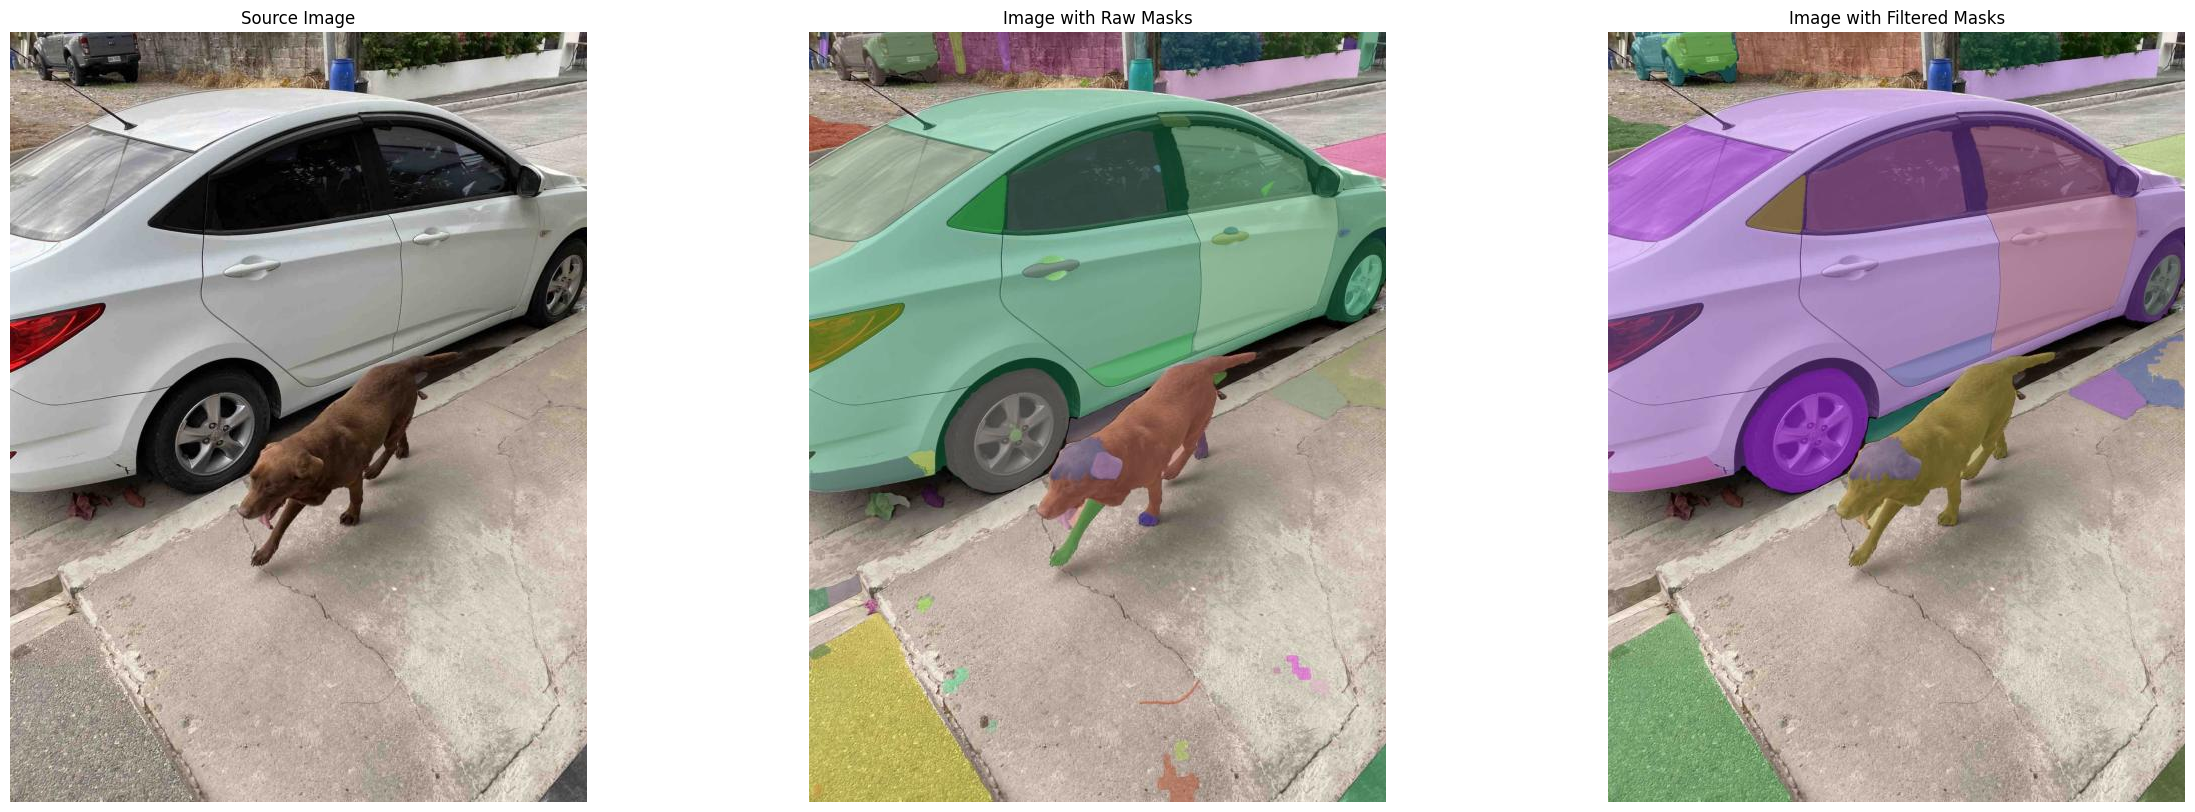

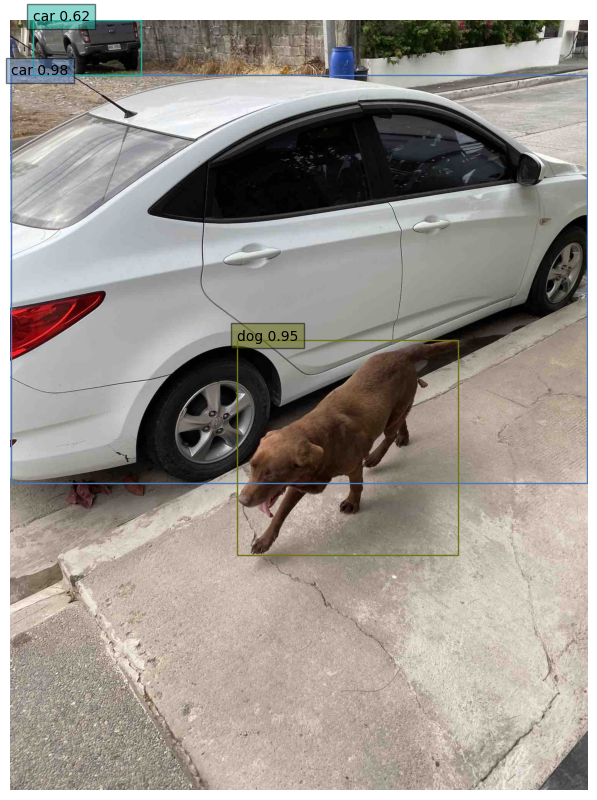

In [118]:
# create output folder for this image
if not os.path.exists("../output"):
    os.mkdir(f"../output")
shutil.rmtree("../output/")
os.mkdir(f"../output/")


image = io.imread(image_link)
height, width = image.shape[:2]
imageArea = height * width
maskArea = 0.0025 * imageArea

# save original image for future analysis
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.savefig(f"../output/source.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

raw_masks = generate_masks(image)    
if VERBOSE_LOGGING:
    print(f"generated {len(raw_masks)} masks...")
    
filtered_masks = filter_masks(raw_masks, maskArea)
if VERBOSE_LOGGING:
    print(f"masks filtered down to {len(filtered_masks)} masks...")

plt.figure(figsize=(10, 10))
plt.imshow(image)

if VERBOSE_LOGGING:
    print("applying raw masks on source image...")

show_anns(raw_masks)
plt.axis('off')
plt.savefig(f"../output/generated-raw-masks.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

plt.figure(figsize=(10, 10))
plt.imshow(image)

if VERBOSE_LOGGING:
    print("applying filtered masks on source image...")
    
show_anns(filtered_masks)
plt.axis('off')
plt.savefig(f"../output/generated-filtered-masks.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

source_image = io.imread(f"../output/source.jpg")
fig, axs = plt.subplots(1, 3,figsize=(30, 10))
axs[0].imshow(source_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Source Image")
masked_image = io.imread(f"../output/generated-raw-masks.jpg")
axs[1].imshow(masked_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Image with Raw Masks")
masked_image = io.imread(f"../output/generated-filtered-masks.jpg")
axs[2].imshow(masked_image, cmap='gray')
axs[2].axis('off')
axs[2].set_title("Image with Filtered Masks")
plt.subplots_adjust(wspace=0.1)
plt.show()
plt.close()

if VERBOSE_LOGGING:
    print("saving cropped mask image files...")
# save mask image files
# save_raw_mask_images(image, raw_masks)
save_mask_images(image, filtered_masks)

# print(f"({image_index}): generating labels...")
generated_labels, generated_probs = generate_labels(filtered_masks)

plt.figure(figsize=(10, 10))
plt.imshow(image)
shows_masks_with_labels(filtered_masks, generated_labels, generated_probs)
plt.axis('off')
plt.savefig(f"../output/generated-masks-labels.jpg",
            bbox_inches='tight', pad_inches=0)
plt.close()

infer_model(image=image_link)

clean_generated_labels = list(set(generated_labels)) # removes duplicates, if any


if input_mode == "random":
    print("image ID:", image_ID, "category ID:", image_category_ID)
    annIds = coco_caps.getAnnIds(imgIds=image_ID)
    anns = coco_caps.loadAnns(annIds)
    ground_truth_labels = []
    ground_truth = []
    for ann in anns:
        ground_truth_labels.append(ann['caption'])
        words = ann['caption'].split()
        for word in words:
            ground_truth.append(word.lower())
    ground_truth_values = list(set(ground_truth))

    # for each mask image, annotate using open-clip
    save_labels(filtered_masks, generated_labels, generated_probs)
 
    ground_truth_string = " ".join(ground_truth_labels)
    
    top_one_scores.append(clean_generated_labels[0] in ground_truth_string)
    top_five_scores.append(isTopNAccurate(
        clean_generated_labels, ground_truth_string))

In [119]:
if (input_mode == "random"):    
    json_object = json.dumps(coco_results, indent=4)
    with open("../output/results.json", "w") as outfile:
        outfile.write(json_object)
    cocoDt = cocoGt.loadRes("../output/results.json")
    cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
    cocoEval.params.imgIds = [image_ID]
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

In [120]:
print("GENERATED LABELS")
pprint(clean_generated_labels)
if (input_mode == "random"):
    print("GROUND TRUTH LABELS")
    pprint(ground_truth_labels)

if (input_mode == "random"):  
    print("-------------------------")
    print("op-1 Accuracy SCORE")
    top_one_score = top_one_scores.count(True)/len(top_one_scores)
    print(top_one_score)
    print("Top-5 Accuracy SCORE")
    top_five_score = top_five_scores.count(True)/len(top_five_scores)
    print(top_five_score)

GENERATED LABELS
['remote',
 'window',
 'cow',
 'pizza',
 'car',
 'boat',
 'skateboard',
 'potted plant',
 'dog',
 'truck']


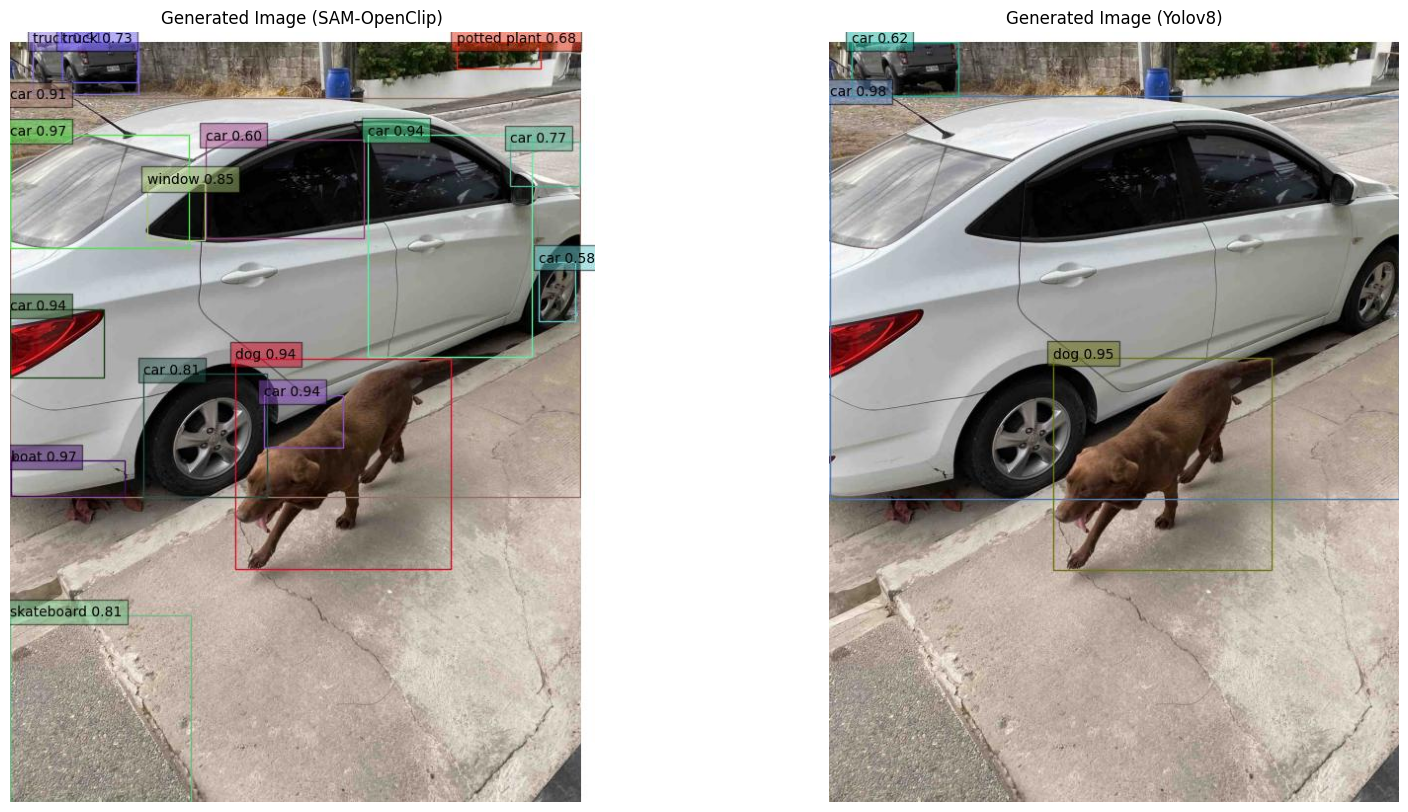

In [121]:

generated_image = io.imread(f"../output/generated-masks-labels.jpg")
fig, axs = plt.subplots(1, 2,figsize=(20, 10))
axs[0].imshow(generated_image, cmap='gray')
axs[0].axis('off')
axs[0].set_title("Generated Image (SAM-OpenClip)")
yolo_image = io.imread(f"../output/yolo-masks-labels.jpg")
axs[1].imshow(yolo_image, cmap='gray')
axs[1].axis('off')
axs[1].set_title("Generated Image (Yolov8)")
plt.subplots_adjust(wspace=0.1)
plt.show()
plt.close()